## Genetic Algorithm for the Knapsack Problem
 
 ### Description of our scenario
 
 - Gene: an item which we can carry or not, represented as a tuple (value,weight).
 - Individual (aka “chromosome”): any possible combination of items (whether they exceed the capacity of the knapsack or not)
 - Fitness: a function that tells us how good each combination is (in our case, how high the value is)

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

### Representation of an Individual Solution 

We need to create our initial population, so we will define a function that will produce random combinations (binary vectors where 1 indicates the inclusion of an item and 0 indicates exclusion) of items. We will check if they fit or not in the knapsack by using the fitness function.

In [3]:
def createCombination(v):
    length = len(v)
    comb = random.sample([0,1], k = length, counts = [length, length])
    return comb

### Initialization

Now we use the function we have already defined to define the function that creates our initial population:

In [4]:
def initialPopulation(popSize, v):
    population = []

    for i in range(0, popSize):
        population.append(createCombination(v))
    return population

### Fitness function

A combination will be better if it has a higher added up value, but it will be penalized if it does exceed the knapsack capacity

In [5]:
def valueFitness(comb):
    totalvalue = 0
    for i in range(0, len(comb)):
        if comb[i]==1:
            totalvalue += items[i][0]
            
    totalweight = 0
    for i in range(0, len(comb)):
        if comb[i]==1:
            totalweight += items[i][1]
            
    penalized = 1
    if totalweight > knapsack_capacity:
        penalized = 0.4
        
    fitness = totalvalue * penalized
    return fitness

To simulate our “survival of the fittest”, we use this function to rank each individual in the population. Our output will be an ordered list with the combinations IDs (index in population) and each associated fitness score.

In [6]:
def rankCombs(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = valueFitness(population[i])
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

### Selection method

We would have to select a subgroup from the population such that this group constitutes the mating pool. For this, we need to define a selection mechanism. Let's see:

In [7]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
        
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Now that we have the IDs of the combinations that will make up our mating pool from the selection function, we can create the mating pool. We’re simply extracting the selected individuals from our population.

In [8]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

### Crossover 
We will implement a simple crossover: pick a crossover point and splice the two strings together to produce an offspring.

In [9]:
def breed(parent1, parent2):
    child = []
    length = len(parent1)
    splitpoint = random.randint(0, length)

    for i in range(0, splitpoint):
        child.append(parent1[i])
        
    for i in range(splitpoint, length):
        child.append(parent2[i])
        
    return child

Next we'll generalize this to create our offspring population

In [10]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

### Mutation

Mutation will simply consist of assigning a low probability of a gene changing from 0 to 1, or vice versa.

In [11]:
mRate = 0.01

In [12]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            if individual[swapped] == 0:
                individual[swapped] = 1
            else:
                individual[swapped] = 0
            
    return individual

Next, we can extend the mutate function to run through the new population.

In [13]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

### Creating a New Generation

Let’s pull these pieces together to create a function that produces a new generation. First, we rank the combinations in the current generation using rankCombs. We then determine our potential parents by running the selection function, which allows us to create the mating pool using the matingPool function. Finally, we then create our new generation using the breedPopulation function and then applying mutation using the mutatePopulation function.

In [14]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankCombs(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

### Termination Condition

Finally, we will impose a termination condition. In this way, we can automate the creation of new generations, stopping once we have reached a satisfactory fitness level or when we've already iterated too much. In our case, we won't iterate more than 500 times.

In [15]:
ngenerations = 500

The following function is useful for automating the creation of generations we've discussed.

In [16]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial value: " + str(rankCombs(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final value: " + str(rankCombs(pop)[0][1]))
    bestCombIndex = rankCombs(pop)[0][0]
    bestComb = pop[bestCombIndex]
    return bestComb

### Running the genetic algorithm

Finally, we can apply this last function in order to apply genetic algorithm to our sample of data and, in this way, solve out Knapsack Problem. Our sample data is the following:

In [17]:
items = [(60, 10), (100, 20), (120, 30)]  # Each tuple is (value, weight)
knapsack_capacity = 50

In [18]:

pSize = 4
eSize = 2
geneticAlgorithm(population=items, popSize=pSize, eliteSize=eSize, mutationRate=mRate, generations=ngenerations)

Initial value: 120


Final value: 180


[1, 0, 1]

### Plot the improvement

In [19]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(rankCombs(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(rankCombs(pop)[0][1])
        
    
    plt.plot(progress)
    plt.ylabel('Value')
    plt.xlabel('Generation')
    plt.show()

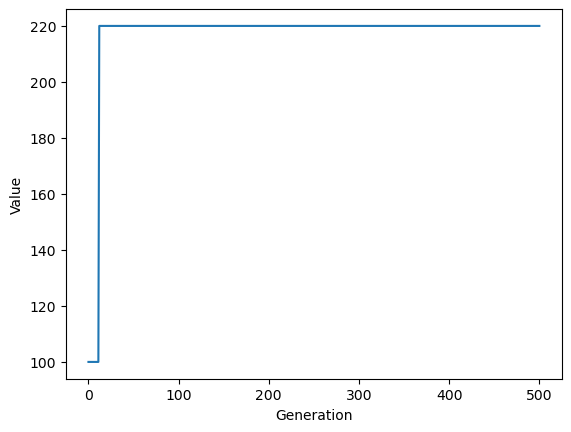

In [22]:
geneticAlgorithmPlot(population=items, popSize=pSize, eliteSize=eSize, mutationRate=mRate, generations=ngenerations)